<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Colab Notebooks/Assignment 14/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Colab Notebooks/Assignment 14/storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [5]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666273e-13,4.613423e-13,1.043041e-05,6.677010e-13,2.451044e-13,3.584581e-12,-2.038017e-11,5.397516e-13,1.068940e-06,1.192360e-12,2.279351e-12,3.580838e-12,-7.216120e-13,3.926113e-13,1.983694e-06,1.545078e-13,8.108365e-13,1.719701e-14,-1.355366e-12,4.675303e-13,1.128585e-06,6.616587e-14,9.770975e-13,4.159749e-14
1,322123,1677099,1,0,0.222222,0.000000,0.377964,1,5,4,7,0,2,3.756867,0,1,3,0.408248,0.447214,0.855462,0.182574,1.263710,1.302675,4.042322e-07,6.042735e-07,0.000735,0.000750,1.830552e-19,4.006357e-16,2.781260e-18,1.148602e-17,-1.076005e-15,9.767058e-15,4.694098e-14,7.653132e-16,5.220938e-15,3.306115e-18,-1.202157e-14,3.020712e-14,4.073948e-13,3.616839e-13,8.699157e-15,7.390923e-15,-1.208461e-16,9.316649e-17,3.533975e-15,3.410019e-15,3.919885e-17,5.183654e-17,-2.727458e-15,4.907336e-13,2.357250e-12,6.835121e-14,2.359175e-13,2.140843e-16
2,626646,614513,1,0,0.000000,0.000000,0.000000,3,12,4,11,0,0,0.000000,0,1,5,0.277350,0.447214,0.724564,0.124035,1.001914,1.171777,4.201434e-07,1.975284e-06,0.000743,0.000777,2.960313e-17,2.049933e-17,6.600688e-16,1.367294e-15,-5.839202e-15,1.405745e-14,1.336905e-12,1.180238e-15,2.028927e-14,5.461876e-16,-6.564308e-15,1.378518e-12,1.005352e-12,4.751569e-15,7.328454e-14,3.787012e-16,-2.074347e-13,7.122288e-14,6.487722e-11,6.828747e-14,6.557980e-14,1.230307e-14,-2.952315e-15,8.906396e-14,3.367675e-11,7.626442e-15,4.737248e-14,2.548252e-14
3,1480505,438127,1,0,0.037736,0.029074,0.088045,28,13,43,12,2,2,2.199298,1,1,2,0.267261,0.150756,0.418017,0.040291,0.685278,0.568773,1.382428e-06,1.440235e-06,0.000844,0.000781,8.361888e-16,3.796861e-17,1.773511e-15,1.462193e-17,-2.956013e-13,8.401623e-10,2.814695e-09,4.562665e-13,1.570047e-11,1.542795e-14,-3.932552e-14,8.589877e-11,2.351120e-11,3.328023e-14,2.015177e-13,7.004797e-16,-1.361283e-12,3.782269e-10,1.990060e-09,2.000301e-12,4.451148e-12,3.305662e-14,-1.870572e-13,1.721327e-11,2.918477e-11,2.780791e-13,6.066354e-12,2.725432e-16
4,1820758,993058,1,0,0.000000,0.000000,0.000000,22,6,8,3,0,0,0.000000,0,1,3,0.377964,0.333333,0.711298,0.125988,1.089262,1.044631,2.707612e-06,6.554011e-07,0.000815,0.000754,7.499897e-17,6.311480e-18,5.074580e-15,1.755738e-15,-9.999632e-12,6.996020e-14,2.544770e-12,6.526090e-15,5.267153e-14,1.383646e-15,-1.300079e-14,3.969592e-14,1.010967e-14,1.564325e-15,2.426041e-14,1.163624e-16,-1.625782e-12,1.218278e-12,1.132761e-11,1.076139e-13,4.373670e-12,9.458543e-14,-3.060016e-13,3.540476e-15,5.119829e-12,3.580570e-16,1.000998e-13,3.272533e-14


In [6]:
#adding new features to the existing dataset

**Preferencil Attachment :**
We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

In [7]:
df_final_train['prefer_attachment'] = df_final_train['num_followers_s'] * df_final_train['num_followers_d']
df_final_test['prefer_attachment'] = df_final_test['num_followers_s'] * df_final_test['num_followers_d']

**SVD_DOT:** Dot product between sourse node svd and destination node svd features.

In [8]:
df_final_train['svd_dot'] = df_final_train['svd_u_d_1']*df_final_train['svd_u_s_1']+df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2']+df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3']+df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4']+df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5']+df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6']
df_final_test['svd_dot'] = df_final_test['svd_u_d_1']*df_final_test['svd_u_s_1']+df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2']+df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3']+df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4']+df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5']+df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6']

In [9]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefer_attachment,svd_dot
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666273e-13,4.613423e-13,1.043041e-05,6.677010e-13,2.451044e-13,3.584581e-12,-2.038017e-11,5.397516e-13,1.068940e-06,1.192360e-12,2.279351e-12,3.580838e-12,-7.216120e-13,3.926113e-13,1.983694e-06,1.545078e-13,8.108365e-13,1.719701e-14,-1.355366e-12,4.675303e-13,1.128585e-06,6.616587e-14,9.770975e-13,4.159749e-14,66,1.114948e-11
1,322123,1677099,1,0,0.222222,0.000000,0.377964,1,5,4,7,0,2,3.756867,0,1,3,0.408248,0.447214,0.855462,0.182574,1.263710,1.302675,4.042322e-07,6.042735e-07,0.000735,0.000750,1.830552e-19,4.006357e-16,2.781260e-18,1.148602e-17,-1.076005e-15,9.767058e-15,4.694098e-14,7.653132e-16,5.220938e-15,3.306115e-18,-1.202157e-14,3.020712e-14,4.073948e-13,3.616839e-13,8.699157e-15,7.390923e-15,-1.208461e-16,9.316649e-17,3.533975e-15,3.410019e-15,3.919885e-17,5.183654e-17,-2.727458e-15,4.907336e-13,2.357250e-12,6.835121e-14,2.359175e-13,2.140843e-16,5,1.975372e-26
2,626646,614513,1,0,0.000000,0.000000,0.000000,3,12,4,11,0,0,0.000000,0,1,5,0.277350,0.447214,0.724564,0.124035,1.001914,1.171777,4.201434e-07,1.975284e-06,0.000743,0.000777,2.960313e-17,2.049933e-17,6.600688e-16,1.367294e-15,-5.839202e-15,1.405745e-14,1.336905e-12,1.180238e-15,2.028927e-14,5.461876e-16,-6.564308e-15,1.378518e-12,1.005352e-12,4.751569e-15,7.328454e-14,3.787012e-16,-2.074347e-13,7.122288e-14,6.487722e-11,6.828747e-14,6.557980e-14,1.230307e-14,-2.952315e-15,8.906396e-14,3.367675e-11,7.626442e-15,4.737248e-14,2.548252e-14,36,1.364970e-24
3,1480505,438127,1,0,0.037736,0.029074,0.088045,28,13,43,12,2,2,2.199298,1,1,2,0.267261,0.150756,0.418017,0.040291,0.685278,0.568773,1.382428e-06,1.440235e-06,0.000844,0.000781,8.361888e-16,3.796861e-17,1.773511e-15,1.462193e-17,-2.956013e-13,8.401623e-10,2.814695e-09,4.562665e-13,1.570047e-11,1.542795e-14,-3.932552e-14,8.589877e-11,2.351120e-11,3.328023e-14,2.015177e-13,7.004797e-16,-1.361283e-12,3.782269e-10,1.990060e-09,2.000301e-12,4.451148e-12,3.305662e-14,-1.870572e-13,1.721327e-11,2.918477e-11,2.780791e-13,6.066354e-12,2.725432e-16,364,1.383489e-19
4,1820758,993058,1,0,0.000000,0.000000,0.000000,22,6,8,3,0,0,0.000000,0,1,3,0.377964,0.333333,0.711298,0.125988,1.089262,1.044631,2.707612e-06,6.554011e-07,0.000815,0.000754,7.499897e-17,6.311480e-18,5.074580e-15,1.755738e-15,-9.999632e-12,6.996020e-14,2.544770e-12,6.526090e-15,5.267153e-14,1.383646e-15,-1.300079e-14,3.969592e-14,1.010967e-14,1.564325e-15,2.426041e-14,1.163624e-16,-1.625782e-12,1.218278e-12,1.132761e-11,1.076139e-13,4.373670e-12,9.458543e-14,-3.060016e-13,3.540476e-15,5.119829e-12,3.580570e-16,1.000998e-13,3.272533e-14,132,1.597952e-25


In [10]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [11]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [12]:
from lightgbm import LGBMClassifier

Estimators =  10 Train Score 0.9730049341434571 test Score 0.933293866418589
Estimators =  50 Train Score 0.973392642167765 test Score 0.9314766537377334
Estimators =  100 Train Score 0.973637782106326 test Score 0.931692020848341
Estimators =  250 Train Score 0.9756370479629723 test Score 0.931560223615111
Estimators =  450 Train Score 0.9785167536878391 test Score 0.9294264708998072


Text(0.5, 1.0, 'Estimators vs learning rate of 0.01')

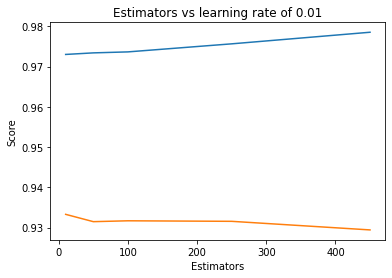

In [13]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = LGBMClassifier(class_weight='balanced', n_estimators=i, n_jobs=-1,random_state=25,verbose=0,learning_rate=0.01)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs learning rate of 0.01')

depth =  0.0001 Train Score 0.9725167624276689 test Score 0.9332374039824788
depth =  0.001 Train Score 0.9729834434385449 test Score 0.933293866418589
depth =  0.01 Train Score 0.9737910216402537 test Score 0.9317030789769235
depth =  0.1 Train Score 0.986514428653561 test Score 0.9284244904884101
depth =  0.2 Train Score 0.9953902240612227 test Score 0.9240263885933178
depth =  0.3 Train Score 0.990500889599228 test Score 0.8986916050079197


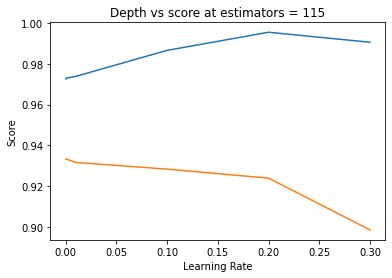

In [14]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
train_scores = []
test_scores = []
for i in learning_rate:
    clf = LGBMClassifier(class_weight='balanced', learning_rate=i, n_jobs=-1,random_state=25,verbose=0,n_estimators=115)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(learning_rate,train_scores,label='Train Score')
plt.plot(learning_rate,test_scores,label='Test Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 115')
plt.show()

In [31]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":[np.random.randint(10,100)],
              "leaning_rate":[np.random.randint(0,1)]}

clf = LGBMClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])

mean test scores [0.97608343]


In [32]:
print(rf_random.best_estimator_)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', leaning_rate=0, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=37, n_jobs=-1, num_leaves=31,
               objective=None, random_state=25, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [34]:
clf=rf_random.best_estimator_

In [35]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [36]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9774860238836862
Test f1 score 0.9310680433310765


In [37]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


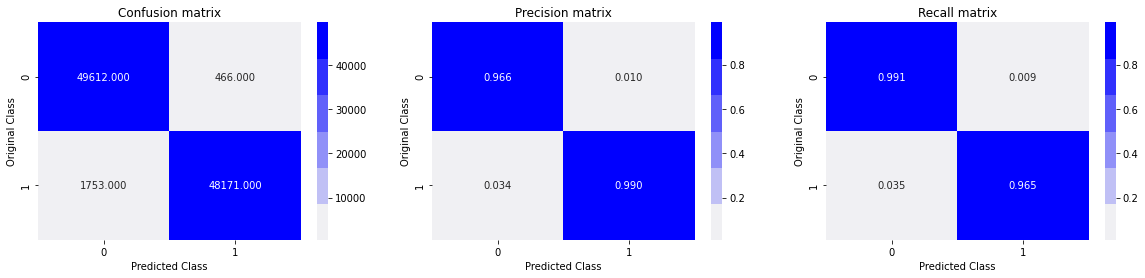

Test confusion_matrix


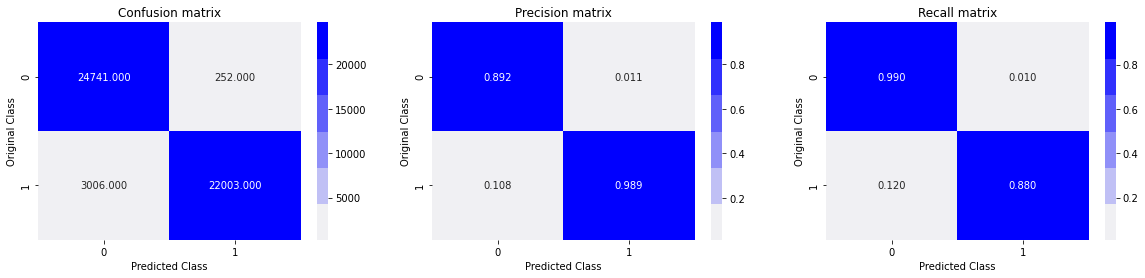

In [38]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

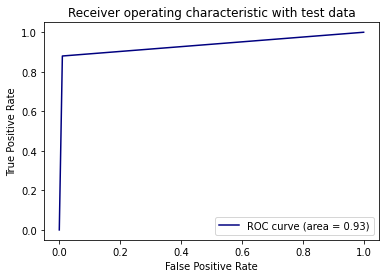

In [39]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

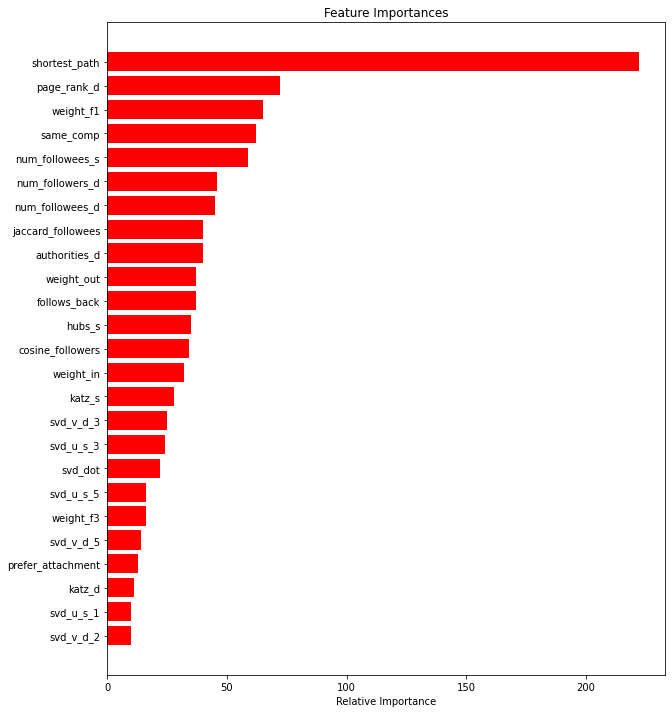

In [40]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.